# Floaty MLP
#### 

## Import the acquired data and define an evaluation function for testing
Obtained by means of several runs on different input trajectories

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model

def load_floaty_full_data(file_path):
    """
    Loads the Floaty dataset from a .csv file and returns:
    - All relevant data concatenated in columns (excluding accelerations)
    - Individual arrays for reference
    """

    # Load CSV file into a DataFrame
    df = pd.read_csv(file_path)
    print(f"Loaded dataset with shape: {df.shape}")

    # Extract data by column name patterns
    lin_pos = df[[col for col in df.columns if col.startswith("lin_pos_")]].to_numpy()
    lin_vel = df[[col for col in df.columns if col.startswith("lin_vel_")]].to_numpy()
    lin_acc = df[[col for col in df.columns if col.startswith("lin_acc_")]].to_numpy()
    angles  = df[[col for col in df.columns if col.startswith("angle_")]].to_numpy()
    ang_rate = df[[col for col in df.columns if col.startswith("ang_rate_")]].to_numpy()
    ang_acc = df[[col for col in df.columns if col.startswith("ang_acc_")]].to_numpy()
    U = df[[col for col in df.columns if col.startswith("U_")]].to_numpy()

    # Concatenate only the desired columns (exclude accelerations)
    concatenated = np.concatenate([lin_pos, lin_vel, angles, ang_rate], axis=1)

    print(f"Concatenated data shape (without accelerations): {concatenated.shape}")

    return lin_pos, lin_vel, lin_acc, angles, ang_rate, ang_acc, U, concatenated


# Example usage
file_path = 'estimated_data2.csv'
experiment_params = {}
experiment_params['data_file'] = file_path # in case more datasets are loaded and merged, I will insert manually a string
lin_pos, lin_vel, lin_acc, angles, ang_rate, ang_acc, U, X = load_floaty_full_data(file_path)

# Compute ΔX[t] = X[t+1] - X[t]
Y = X[1:] - X[:-1]
X = X[:-1]
U = U[:-1]
# Training input
Z = np.concatenate([X,U], axis=1)

print(f"Training inputs shape: {Z.shape}, targets shape: {Y.shape}")


def test_keras_model_grouped(model_path, X_test, Y_test, sc_out, plot_dim=12):
    """
    Tests a trained Keras model on the test dataset.
    Shows detailed metrics grouped by 3-column physical groups and separate plots for each output.
    """

    # --- Load model ---
    model = load_model(model_path)
    print(f"Loaded model from: {model_path}")

    #model = model

    # --- Predict ---
    Y_pred = model.predict(X_test, verbose=0)

    # --- Denormalize predictions and ground truth ---
    Y_pred_phys = sc_out.inverse_transform(Y_pred)
    Y_true_phys = sc_out.inverse_transform(Y_test)

    # --- Compute overall metrics ---
    mse = mean_squared_error(Y_true_phys, Y_pred_phys)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_true_phys, Y_pred_phys)
    r2 = r2_score(Y_true_phys, Y_pred_phys)
    print("\n--- Overall Test Metrics ---")
    print(pd.DataFrame([{"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}]))

    # --- Define variable and group names ---
    var_names = ["Δx", "Δy", "Δz",
                 "Δvx", "Δvy", "Δvz",
                 "Δroll", "Δpitch", "Δyaw",
                 "Δp", "Δq", "Δr"]

    group_names = ["Linear Position", "Linear Velocity", "Angles", "Angular Rates"]

    # --- Compute metrics per group ---
    group_metrics = []
    for g in range(4):
        start, end = g * 3, (g + 1) * 3
        Yt_g = Y_true_phys[:, start:end]
        Yp_g = Y_pred_phys[:, start:end]
        mse_g = mean_squared_error(Yt_g, Yp_g)
        rmse_g = np.sqrt(mse_g)
        mae_g = mean_absolute_error(Yt_g, Yp_g)
        r2_g = r2_score(Yt_g, Yp_g)
        group_metrics.append([group_names[g], mse_g, rmse_g, mae_g, r2_g])

    df_groups = pd.DataFrame(group_metrics, columns=["Group", "MSE", "RMSE", "MAE", "R2"])

    print("\n--- Metrics by Group ---")
    print(df_groups.to_string(index=False, justify="center", float_format=lambda x: f"{x:10.6f}"))

    # --- Plot each output dimension separately ---
    n_plots = min(plot_dim, Y_true_phys.shape[1])
    for i in range(n_plots):
        plt.figure(figsize=(10, 4))
        plt.plot(Y_true_phys[:200, i], label='True', linewidth=2)
        plt.plot(Y_pred_phys[:200, i], label='Pred', linestyle='--')
        plt.title(f"{var_names[i]} ({group_names[i//3]})")
        plt.xlabel("Sample index")
        plt.ylabel(var_names[i])
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"overall": {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2},
            "groups": df_groups}

Loaded dataset with shape: (14900, 22)
Concatenated data shape (without accelerations): (14900, 12)
Training inputs shape: (14899, 16), targets shape: (14899, 12)


## Dataset shuffling, normalization and splitting

In [5]:
def prepare_dataset( #not shuffling at all any set
    X_all, U_all, Y_all, val_ratio=0.1, test_ratio=0.1, random_seed=None
):
    """
    - Chronological split:
        → TRAIN = first part
        → VAL   = middle part
        → TEST  = last part (ordered)
    - Fit scalers ONLY on TRAIN subset
    - Keep an ordered TEST copy (for rollout)
    """

    # ----- Concatenate inputs -----
    X_in = np.hstack([X_all, U_all])   # shape (N, n_x + n_u)
    Y_out = Y_all                      # shape (N, n_y)
    N = len(X_in)

    # ----- Compute split sizes -----
    n_test = int(test_ratio * N)
    n_val  = int(val_ratio  * N)
    n_train = N - n_val - n_test
    if n_train <= 0:
        raise ValueError("Not enough samples for training. Reduce val_ratio/test_ratio.")

    # ----- Chronological splits -----
    idx_train = np.arange(0, n_train)
    idx_val   = np.arange(n_train, n_train + n_val)
    idx_test  = np.arange(n_train + n_val, N)

    # ----- Fit scalers ONLY on TRAIN subset -----
    sc_in  = StandardScaler().fit(X_in[idx_train])
    sc_out = StandardScaler().fit(Y_out[idx_train])

    # ----- Transform all splits -----
    X_train, Y_train = sc_in.transform(X_in[idx_train]), sc_out.transform(Y_out[idx_train])
    X_val,   Y_val   = sc_in.transform(X_in[idx_val]),   sc_out.transform(Y_out[idx_val])
    X_test,  Y_test  = sc_in.transform(X_in[idx_test]),  sc_out.transform(Y_out[idx_test])

    X_test_ord = X_test.copy()
    Y_test_ord = Y_test.copy()


    # ----- Shuffle all sets -----
    rng = np.random.default_rng(random_seed)

    def shuffle_set(X, Y):
        perm = rng.permutation(len(X))
        return X[perm], Y[perm]

    X_train, Y_train = shuffle_set(X_train, Y_train)
    X_val,   Y_val   = shuffle_set(X_val,   Y_val)
    X_test,  Y_test  = shuffle_set(X_test,  Y_test)

    # ----- Info -----
    print("Scalers fit on TRAIN subset only (no data leakage).")
    print("Split: chronological; TRAIN, VAL, TEST shuffled, saved a copy of unshufled test set for rollout")
    print(f"Shapes -> X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

    return (
        X_train, Y_train,           # non-shuffled train
        X_val, Y_val,               # non-shuffled val
        X_test, Y_test,             # non-shuffled test (for general training)
        X_test_ord, Y_test_ord,
        sc_in, sc_out
    )


# ----- Example usage -----
(
    X_train, Y_train,
    X_val, Y_val,
    X_test, Y_test,                 # shuffled test (for training)
    X_test_ord, Y_test_ord,                 
    sc_in, sc_out
) = prepare_dataset(
    X_all=X, U_all=U, Y_all=Y,
    val_ratio=0.1, test_ratio=0.1, random_seed=42
)


random_seed = 42


(
    X_train, Y_train,
    X_val, Y_val,
    X_test, Y_test,
    X_test_ord, Y_test_ord,
    sc_in, sc_out
) = prepare_dataset(
    X_all=X, U_all=U, Y_all=Y,
    val_ratio=0.1, test_ratio=0.1,
    random_seed=random_seed
)

Scalers fit on TRAIN subset only (no data leakage).
Split: chronological; TRAIN, VAL, TEST shuffled, saved a copy of unshufled test set for rollout
Shapes -> X_train: (11921, 16), X_val: (1489, 16), X_test: (1489, 16)
Scalers fit on TRAIN subset only (no data leakage).
Split: chronological; TRAIN, VAL, TEST shuffled, saved a copy of unshufled test set for rollout
Shapes -> X_train: (11921, 16), X_val: (1489, 16), X_test: (1489, 16)


## MLP
We use tanh because, even if carries with itslef some defects, helps not to smooth out the derivatives and so keeps the system more aderent to reality. A simple 4-layer MLP with small weight matrices is enough to fully capture the features of our system

In [12]:
# Learning parameters
lr = 1e-3
epochs = 600
batch_size = 128

experiment_params['lr'] = lr
experiment_params['epochs'] = epochs
experiment_params['batch_size'] = batch_size

# MLP (actually, I removed residual connections)
inputs = keras.Input(shape=(X_train.shape[1],))

# First block
x = layers.Dense(16, activation='tanh')(inputs)

# # Final layers
# x = layers.Dense(128, activation='tanh')(x)
# x = layers.Dense(128, activation='tanh')(x)
# x = layers.Dense(64, activation='tanh')(x)
outputs = layers.Dense(Y_train.shape[1])(x)

# Build model
model = keras.Model(inputs, outputs)

# Compile
model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse')

layer_sizes = [layer.units for layer in model.layers if hasattr(layer, "units")]
print(layer_sizes)




[16, 12]


## Model Training


🟢 Training up to 100 / 1000 epochs...

Epoch 1/100
45/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4317   
Epoch 1: val_loss improved from None to 0.71402, saving model to checkpoints/best_model_until_100.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1381 - val_loss: 0.7140 - learning_rate: 0.0010
Epoch 2/100
54/94 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.7677
Epoch 2: val_loss improved from 0.71402 to 0.46962, saving model to checkpoints/best_model_until_100.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6745 - val_loss: 0.4696 - learning_rate: 0.0010
Epoch 3/100
56/94 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 0.5267
Epoch 3: val_loss improved from 0.46962 to 0.35967, saving model to checkpoints/best_model_until_100.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4792 - val_loss: 0.3597 - learning_rate: 0.0010
Epoch 4/100
54/94 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.4001
Epoch 4: val_loss improved from 0.35967 to 0.30924, saving model to checkpoint

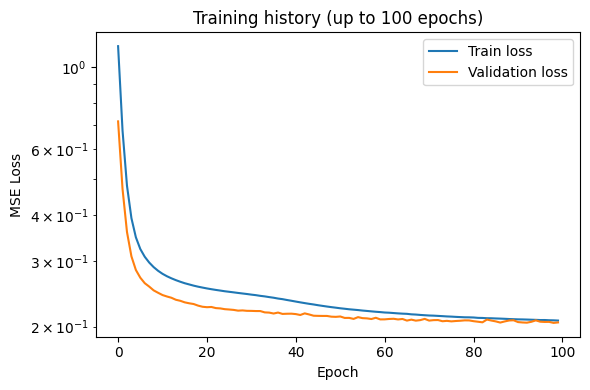


🔍 Evaluating model after 100 epochs...
Loaded model from: checkpoints\model_epoch_100.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.009753  0.098757  0.038977  0.789556

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000336   0.000235   0.991459
Linear Velocity   0.000155   0.012451   0.009163   0.660281
         Angles   0.000008   0.002772   0.001929   0.987726
  Angular Rates   0.038849   0.197102   0.144582   0.518757
📊 Logged metrics: Epoch 100 | MSE = 9.752960e-03, R2 = 0.789556

🟢 Training up to 200 / 1000 epochs...

Epoch 1/100
66/94 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.2074
Epoch 1: val_loss improved from None to 0.20573, saving model to checkpoints/best_model_until_200.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2077 - val_loss: 0.2057 - learning_rate: 0.0010
Epoch 2/100
68/94 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.2048
Epoch 2: val_loss did not 

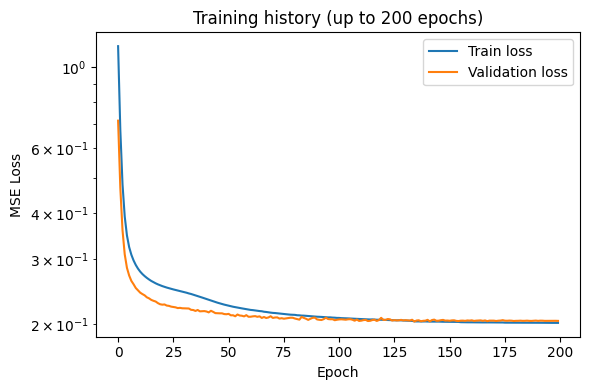


🔍 Evaluating model after 200 epochs...
Loaded model from: checkpoints\model_epoch_200.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.009475  0.097341  0.038252  0.795057

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000296   0.000203   0.993763
Linear Velocity   0.000152   0.012338   0.009059   0.663354
         Angles   0.000007   0.002577   0.001811   0.989328
  Angular Rates   0.037742   0.194273   0.141934   0.533783
📊 Logged metrics: Epoch 200 | MSE = 9.475283e-03, R2 = 0.795057

🟢 Training up to 300 / 1000 epochs...

Epoch 1/100
68/94 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.2073
Epoch 1: val_loss improved from None to 0.20401, saving model to checkpoints/best_model_until_300.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2013 - val_loss: 0.2040 - learning_rate: 6.2500e-05
Epoch 2/100
69/94 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.2017
Epoch 2: val_loss impr

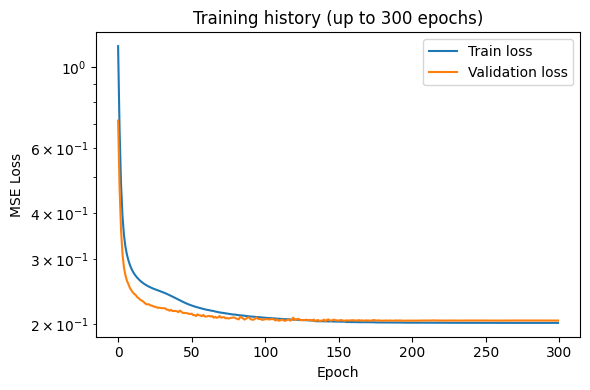


🔍 Evaluating model after 300 epochs...
Loaded model from: checkpoints\model_epoch_300.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.009471  0.097318  0.038224  0.795392

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000294   0.000202   0.993853
Linear Velocity   0.000152   0.012332   0.009056   0.663983
         Angles   0.000007   0.002566   0.001805   0.989465
  Angular Rates   0.037724   0.194228   0.141836   0.534267
📊 Logged metrics: Epoch 300 | MSE = 9.470787e-03, R2 = 0.795392

🟢 Training up to 400 / 1000 epochs...

Epoch 1/100
60/94 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 0.1964
Epoch 1: val_loss improved from None to 0.20402, saving model to checkpoints/best_model_until_400.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2011 - val_loss: 0.2040 - learning_rate: 3.9063e-06
Epoch 2/100
68/94 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 0.2061
Epoch 2: val_loss impr

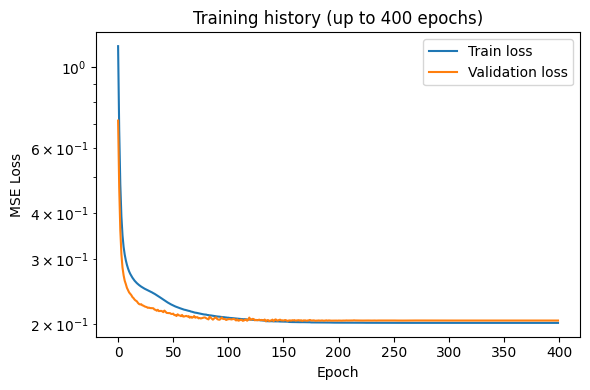


🔍 Evaluating model after 400 epochs...
Loaded model from: checkpoints\model_epoch_400.keras

--- Overall Test Metrics ---
       MSE      RMSE       MAE        R2
0  0.00947  0.097315  0.038223  0.795382

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000293   0.000202   0.993856
Linear Velocity   0.000152   0.012331   0.009055   0.663893
         Angles   0.000007   0.002566   0.001805   0.989466
  Angular Rates   0.037722   0.194221   0.141831   0.534312
📊 Logged metrics: Epoch 400 | MSE = 9.470135e-03, R2 = 0.795382

🟢 Training up to 500 / 1000 epochs...

Epoch 1/100
67/94 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 0.1993
Epoch 1: val_loss improved from None to 0.20402, saving model to checkpoints/best_model_until_500.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2010 - val_loss: 0.2040 - learning_rate: 1.0000e-06
Epoch 2/100
65/94 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.1982
Epoch 2: val_loss improv

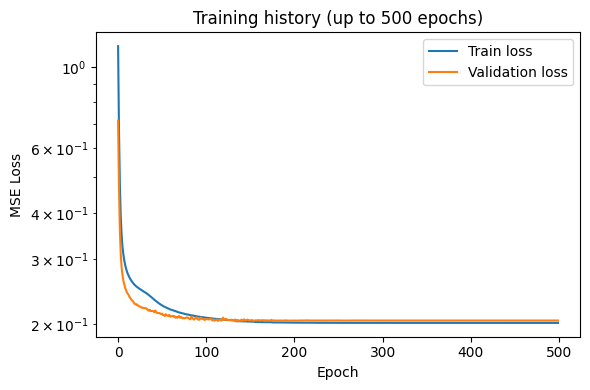


🔍 Evaluating model after 500 epochs...
Loaded model from: checkpoints\model_epoch_500.keras

--- Overall Test Metrics ---
        MSE      RMSE      MAE        R2
0  0.009469  0.097306  0.03822  0.795377

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000293   0.000202   0.993858
Linear Velocity   0.000152   0.012332   0.009056   0.663848
         Angles   0.000007   0.002566   0.001805   0.989468
  Angular Rates   0.037715   0.194205   0.141819   0.534332
📊 Logged metrics: Epoch 500 | MSE = 9.468541e-03, R2 = 0.795377

🟢 Training up to 600 / 1000 epochs...

Epoch 1/100
68/94 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.1992
Epoch 1: val_loss improved from None to 0.20401, saving model to checkpoints/best_model_until_600.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2010 - val_loss: 0.2040 - learning_rate: 1.0000e-06
Epoch 2/100
70/94 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.2050
Epoch 2: val_loss improv

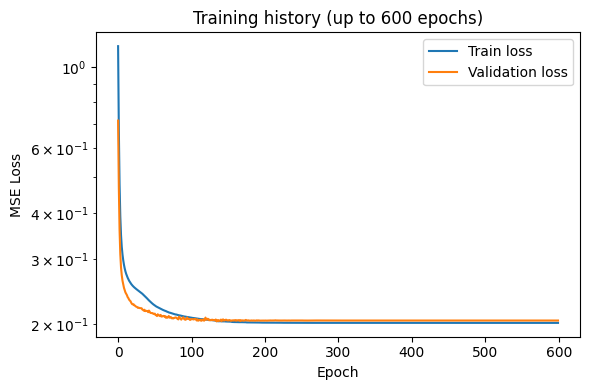


🔍 Evaluating model after 600 epochs...
Loaded model from: checkpoints\model_epoch_600.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.009469  0.097308  0.038221  0.795382

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000293   0.000201   0.993861
Linear Velocity   0.000152   0.012332   0.009056   0.663882
         Angles   0.000007   0.002566   0.001805   0.989469
  Angular Rates   0.037717   0.194208   0.141821   0.534316
📊 Logged metrics: Epoch 600 | MSE = 9.468885e-03, R2 = 0.795382

🟢 Training up to 700 / 1000 epochs...

Epoch 1/100
66/94 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.1998
Epoch 1: val_loss improved from None to 0.20401, saving model to checkpoints/best_model_until_700.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2010 - val_loss: 0.2040 - learning_rate: 1.0000e-06
Epoch 2/100
72/94 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.1995
Epoch 2: val_loss did 

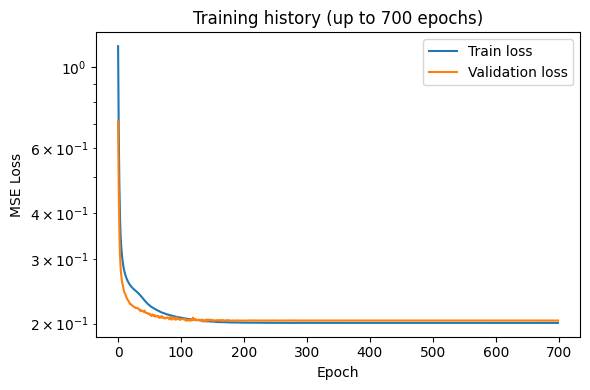


🔍 Evaluating model after 700 epochs...
Loaded model from: checkpoints\model_epoch_700.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.009469  0.097309  0.038221  0.795394

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000293   0.000201   0.993863
Linear Velocity   0.000152   0.012331   0.009055   0.663912
         Angles   0.000007   0.002566   0.001804   0.989472
  Angular Rates   0.037718   0.194210   0.141822   0.534330
📊 Logged metrics: Epoch 700 | MSE = 9.469081e-03, R2 = 0.795394

🟢 Training up to 800 / 1000 epochs...

Epoch 1/100
63/94 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.1983
Epoch 1: val_loss improved from None to 0.20401, saving model to checkpoints/best_model_until_800.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2010 - val_loss: 0.2040 - learning_rate: 1.0000e-06
Epoch 2/100
50/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2059 
Epoch 2: val_loss impro

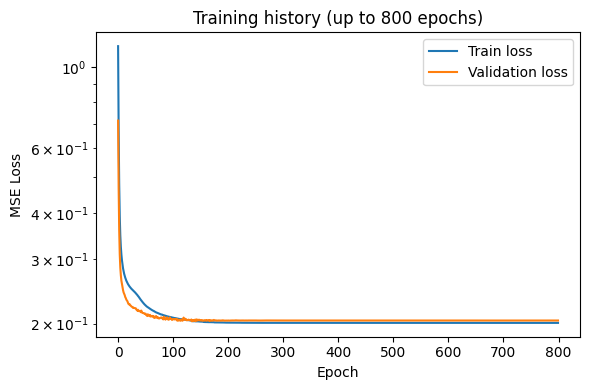


🔍 Evaluating model after 800 epochs...
Loaded model from: checkpoints\model_epoch_800.keras

--- Overall Test Metrics ---
        MSE     RMSE      MAE       R2
0  0.009469  0.09731  0.03822  0.79539

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000293   0.000201   0.993865
Linear Velocity   0.000152   0.012331   0.009055   0.663894
         Angles   0.000007   0.002566   0.001804   0.989473
  Angular Rates   0.037718   0.194211   0.141820   0.534330
📊 Logged metrics: Epoch 800 | MSE = 9.469149e-03, R2 = 0.795390

🟢 Training up to 900 / 1000 epochs...

Epoch 1/100
59/94 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.2000
Epoch 1: val_loss improved from None to 0.20403, saving model to checkpoints/best_model_until_900.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2010 - val_loss: 0.2040 - learning_rate: 1.0000e-06
Epoch 2/100
53/94 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 0.1942
Epoch 2: val_loss improved f

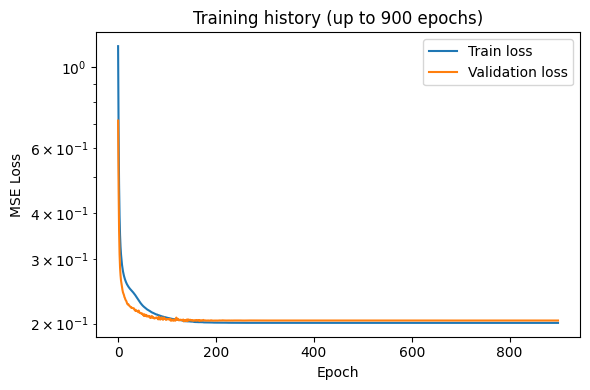


🔍 Evaluating model after 900 epochs...
Loaded model from: checkpoints\model_epoch_900.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.009468  0.097306  0.038218  0.795398

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000293   0.000201   0.993864
Linear Velocity   0.000152   0.012332   0.009055   0.663866
         Angles   0.000007   0.002565   0.001804   0.989475
  Angular Rates   0.037715   0.194203   0.141813   0.534385
📊 Logged metrics: Epoch 900 | MSE = 9.468403e-03, R2 = 0.795398

🟢 Training up to 1000 / 1000 epochs...

Epoch 1/100
63/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2017
Epoch 1: val_loss improved from None to 0.20402, saving model to checkpoints/best_model_until_1000.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2010 - val_loss: 0.2040 - learning_rate: 1.0000e-06
Epoch 2/100
83/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2035
Epoch 2: val_loss did no

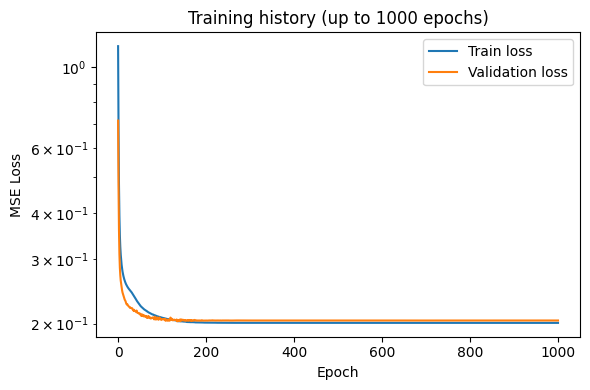


🔍 Evaluating model after 1000 epochs...
Loaded model from: checkpoints\model_epoch_1000.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.009469  0.097309  0.038219  0.795381

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000293   0.000201   0.993867
Linear Velocity   0.000152   0.012333   0.009056   0.663807
         Angles   0.000007   0.002565   0.001804   0.989476
  Angular Rates   0.037718   0.194210   0.141815   0.534373
📊 Logged metrics: Epoch 1000 | MSE = 9.469110e-03, R2 = 0.795381

💾 All experiment parameters and results saved to:
checkpoints\4_all_shuffled.json

📈 Performance summary:
   epochs                          model_path       MSE        R2
0     100   checkpoints\model_epoch_100.keras  0.009753  0.789556
1     200   checkpoints\model_epoch_200.keras  0.009475  0.795057
2     300   checkpoints\model_epoch_300.keras  0.009471  0.795392
3     400   checkpoints\model

In [13]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import joblib
import pandas as pd

# --- Configuration ---
total_epochs = 1000
eval_interval = 100    # evaluate every 100 epochs
batch_size = 128
save_dir = "checkpoints"

os.makedirs(save_dir, exist_ok=True)

# --- Global experiment configuration dictionary ---
experiment_params = {
    "dataset_split" : "Training set shuffled",
    "randdom_seed" : random_seed ,
    "model_name": "MLP",
    "learning_rate": 1e-3,
    "batch_size": batch_size,
    "total_epochs": total_epochs,
    "eval_interval": eval_interval,
    "data_file": file_path,
    "model_summary" : layer_sizes,
    "results": []  # will be filled dynamically
    
}

# --- Callbacks ---
def make_callbacks(current_epoch):
    """Create callbacks for the current training chunk."""
    return [
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=20,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=f"{save_dir}/best_model_until_{current_epoch}.keras",
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        )
    ]

# --- Save scalers once ---
joblib.dump(sc_in, f"{save_dir}/sc_in.joblib")
joblib.dump(sc_out, f"{save_dir}/sc_out.joblib")

# --- Initialize training record ---
history_all = {'loss': [], 'val_loss': []}

# --- Training and evaluation loop ---
for current_epoch in range(eval_interval, total_epochs + 1, eval_interval):
    print(f"\n🟢 Training up to {current_epoch} / {total_epochs} epochs...\n")

    # Train for eval_interval epochs (continues from current weights)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=eval_interval,
        batch_size=batch_size,
        verbose=1,
        callbacks=make_callbacks(current_epoch),
        shuffle=True
    )

    # --- Update training history ---
    history_all['loss'].extend(history.history['loss'])
    history_all['val_loss'].extend(history.history['val_loss'])

    # --- Save model manually every eval_interval ---
    model_save_path = os.path.join(save_dir, f"model_epoch_{current_epoch}.keras")
    model.save(model_save_path)
    print(f"💾 Model saved at {model_save_path}")

    # --- Best epoch so far ---
    best_epoch = np.argmin(history_all['val_loss']) + 1
    best_val_loss = np.min(history_all['val_loss'])
    print(f"\n🏆 Best epoch so far: {best_epoch} with val_loss = {best_val_loss:.6f}\n")

    # --- Plot training history ---
    plt.figure(figsize=(6, 4))
    plt.plot(history_all['loss'], label='Train loss')
    plt.plot(history_all['val_loss'], label='Validation loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title(f'Training history (up to {current_epoch} epochs)')
    plt.tight_layout()
    plt.show()

    # --- Evaluate model ---
    print(f"\n🔍 Evaluating model after {current_epoch} epochs...")
    results = test_keras_model_grouped(
        model_path=model_save_path,   # evaluate the just-saved model
        X_test=X_test,
        Y_test=Y_test,
        sc_out=sc_out,
        plot_dim=0
    )

    # --- Extract metrics ---
    mse = float(results["overall"]["MSE"])
    r2 = float(results["overall"]["R2"])

    experiment_params["results"].append({
        "epochs": current_epoch,
        "model_path": model_save_path,
        "MSE": mse,
        "R2": r2
    })

    print(f"📊 Logged metrics: Epoch {current_epoch} | MSE = {mse:.6e}, R2 = {r2:.6f}")

# --- Save the entire experiment dictionary as JSON ---
json_path = os.path.join(save_dir, "4_all_shuffled.json")
with open(json_path, "w") as f:
    json.dump(experiment_params, f, indent=4)

print(f"\n💾 All experiment parameters and results saved to:\n{json_path}")

# --- Optional: show quick summary ---
df_results = pd.DataFrame(experiment_params["results"])
print("\n📈 Performance summary:")
print(df_results)


## Training performance
We can observe that our model conserves a very good capability of abstraction while on the other hand is very performative to learn

Loaded model from: checkpoints\model_epoch_100.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.009753  0.098757  0.038977  0.789556

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000336   0.000235   0.991459
Linear Velocity   0.000155   0.012451   0.009163   0.660281
         Angles   0.000008   0.002772   0.001929   0.987726
  Angular Rates   0.038849   0.197102   0.144582   0.518757


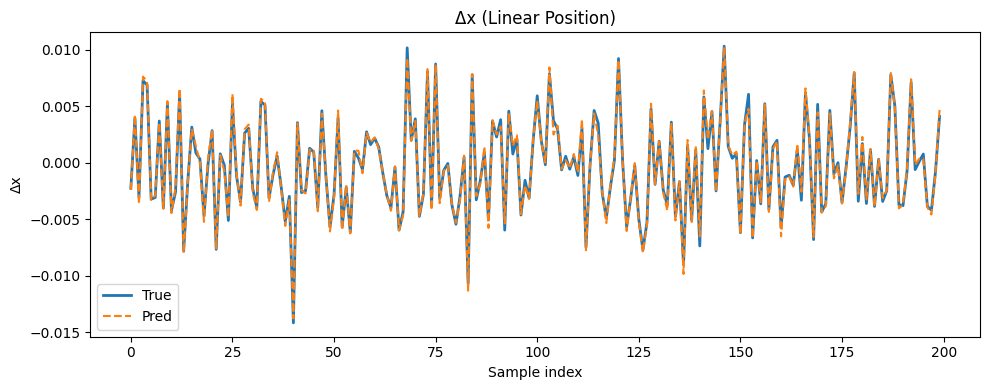

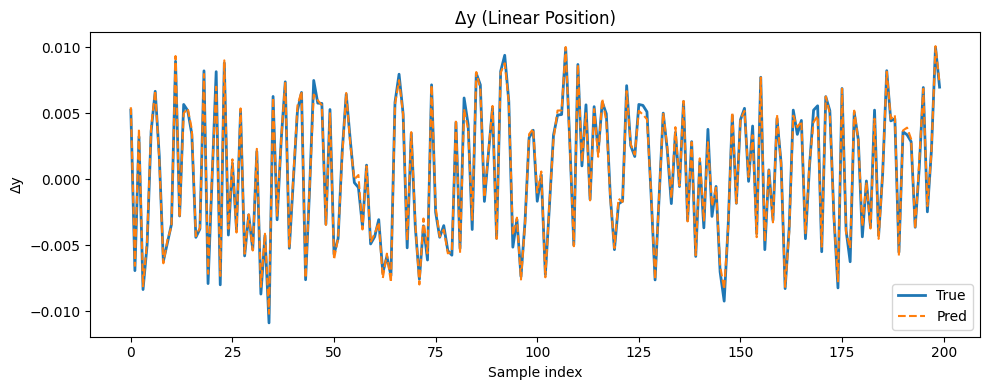

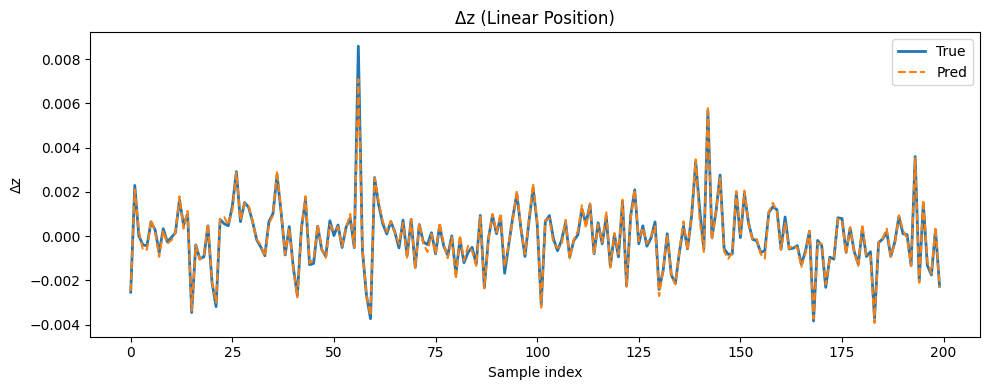

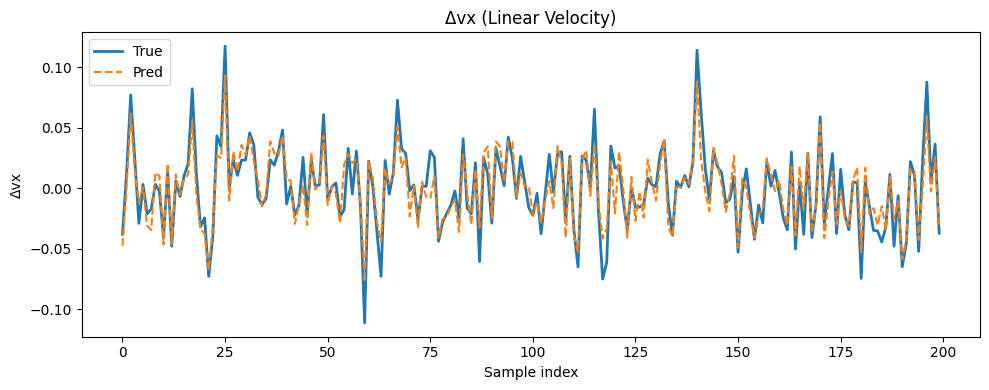

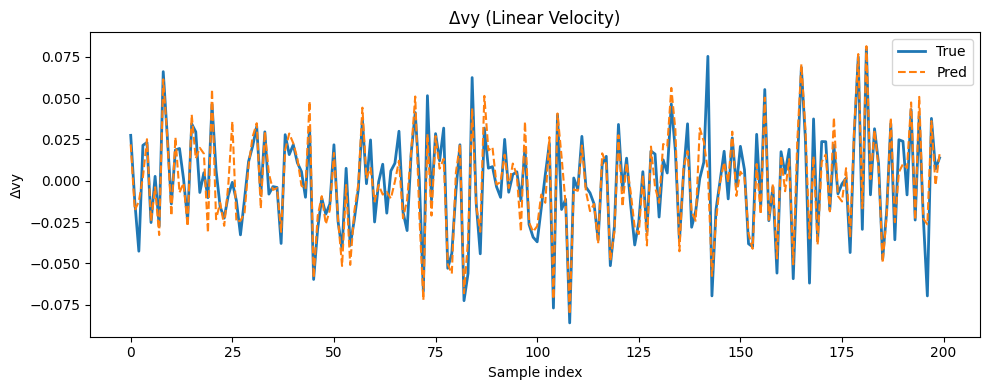

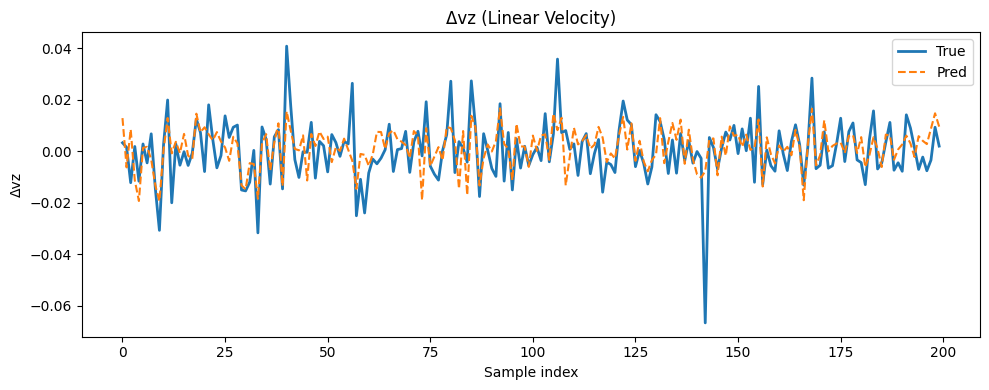

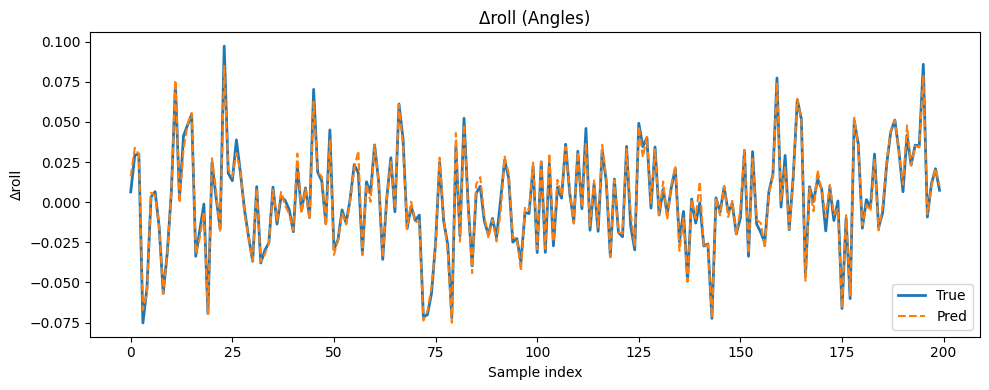

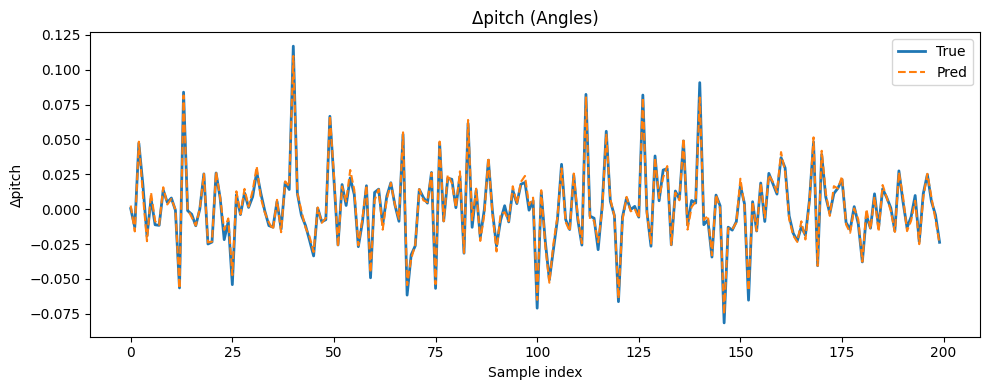

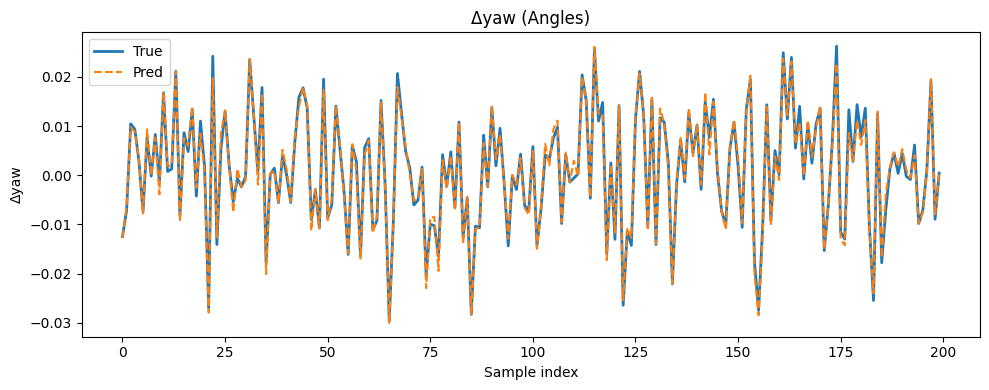

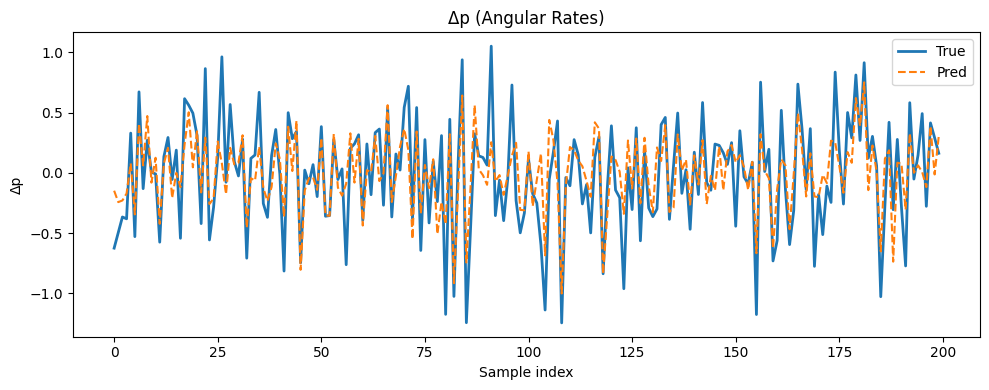

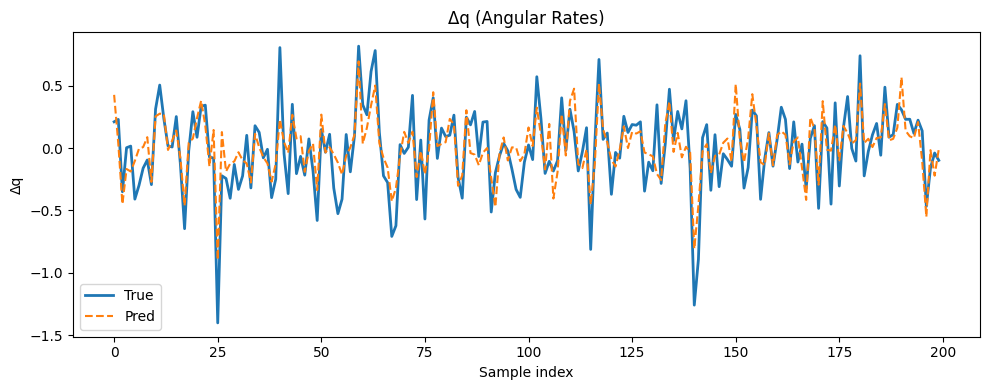

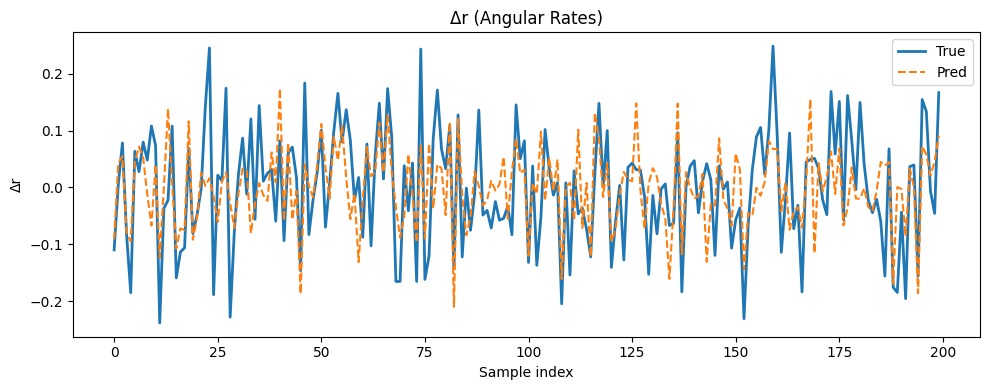

In [15]:
model_path="checkpoints\model_epoch_100.keras"

results3 = test_keras_model_grouped(
    model_path= model_path,
    X_test=X_test,
    Y_test=Y_test,
    sc_out=sc_out,
    plot_dim=12   # number of output dimensions to plot
)

## Testing performances
We have no data left for evaluating a rollout since the test set is composed by shuffled data. Selecting random indices for the training, validation and test set made the net very performative (almost 100%) at understanding the evolution deltaX of the system's dynamics, but makes it impossible to evaluate an open loop rollout on an ordered test set.

Plot limited to first 2.000s (200 samples).


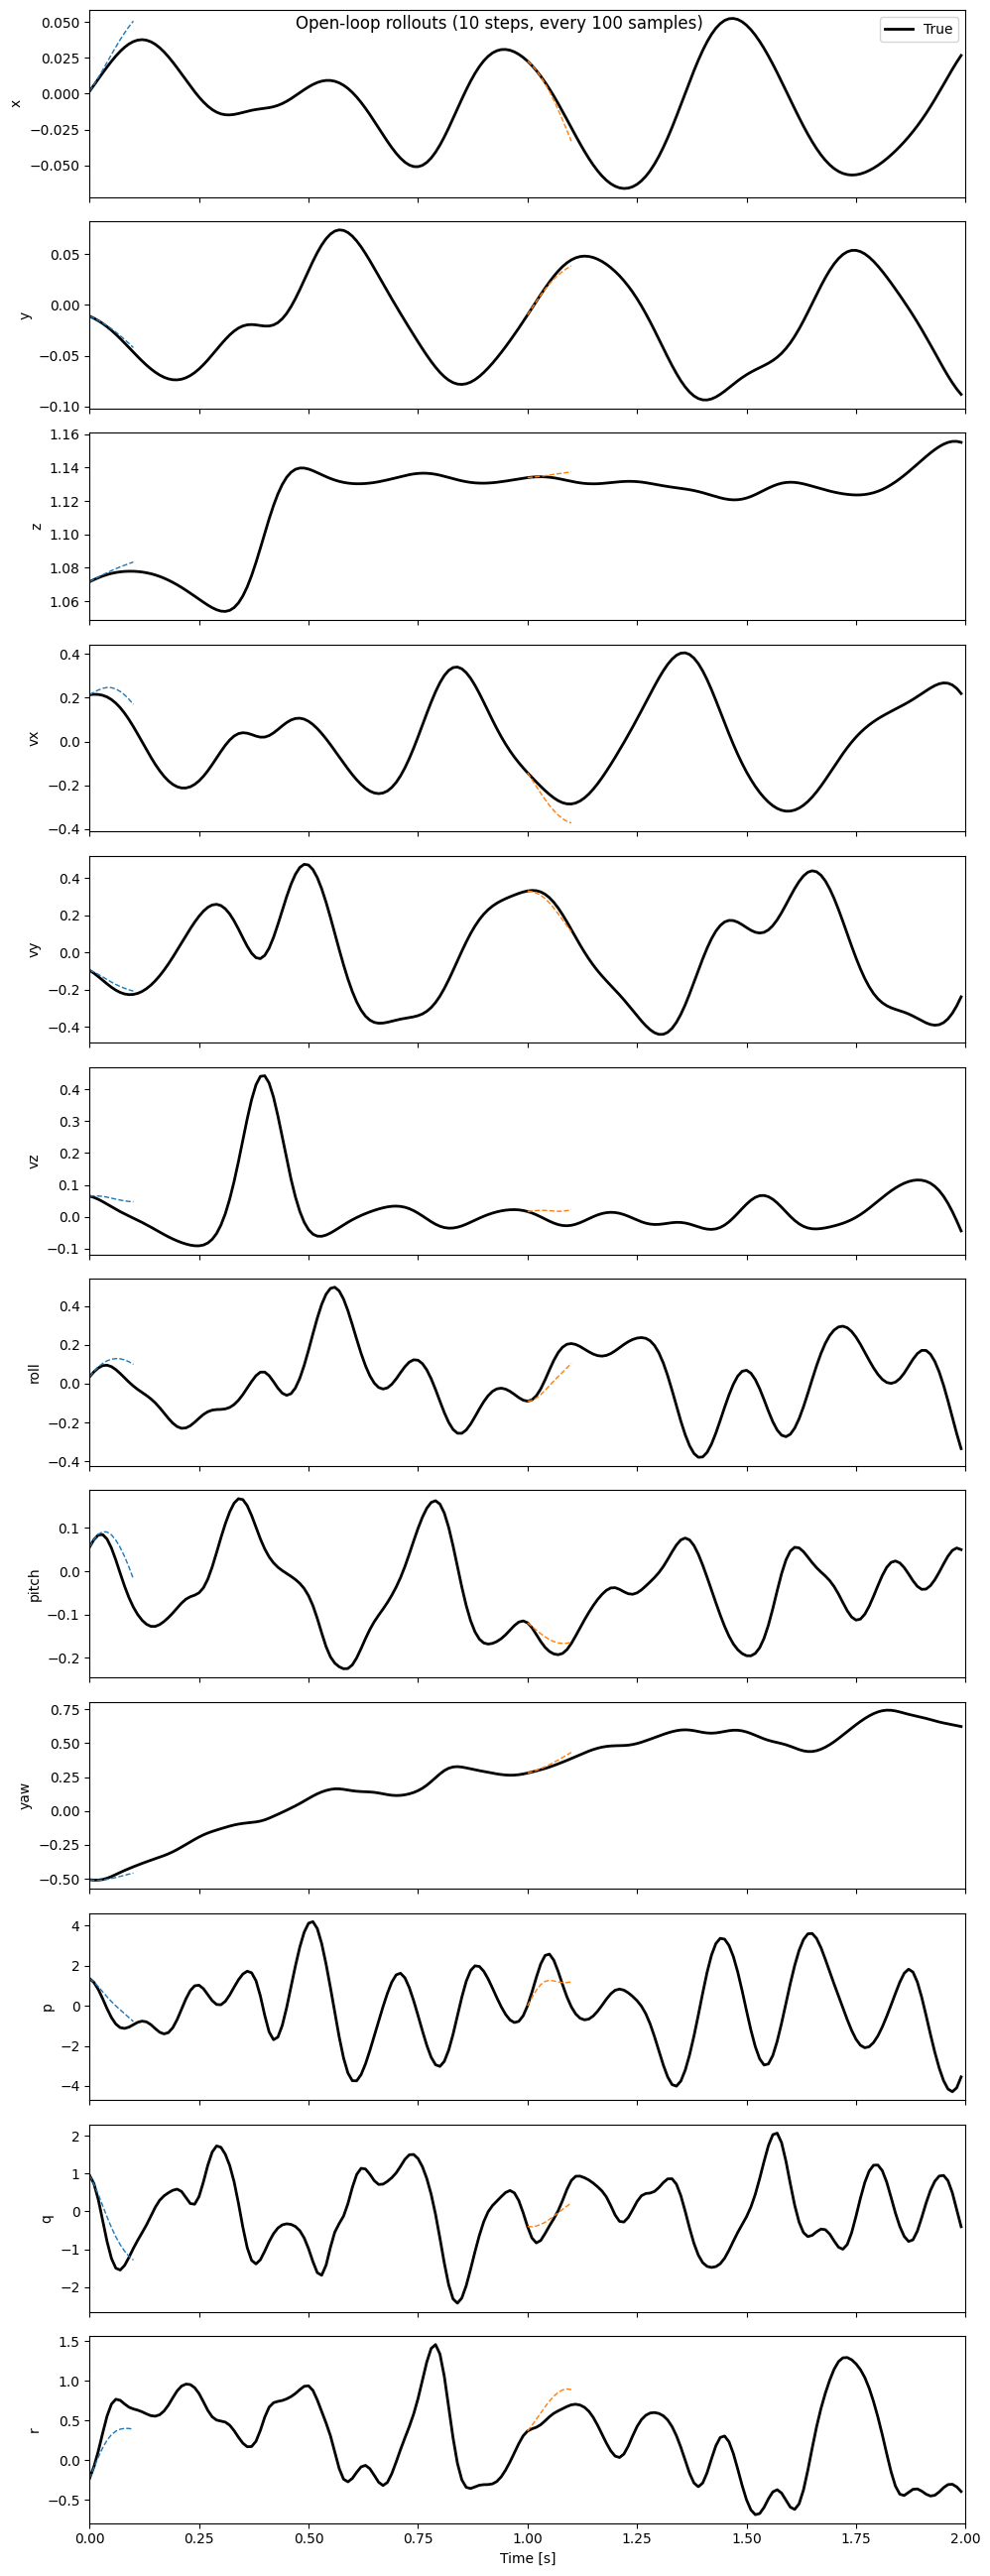


--- Open-loop horizon metrics (physical units) ---
MSE:  9.101804e-02
RMSE: 3.016920e-01
MAE:  1.452468e-01
R2:   -7.496715


In [17]:
def inv_transform_cols(sc, Xn_part, col_start):
    """Inverse-transform selected columns from a fitted StandardScaler."""
    cols = slice(col_start, col_start + Xn_part.shape[1])
    return Xn_part * sc.scale_[cols] + sc.mean_[cols]

def transform_cols(sc, X_part, col_start):
    """Transform selected columns using the fitted StandardScaler."""
    cols = slice(col_start, col_start + X_part.shape[1])
    return (X_part - sc.mean_[cols]) / sc.scale_[cols]

def get_test_states_inputs_physical(X_test, sc_in, n_x):
    """
    From normalized X_test = [X_n, U_n], recover physical X_test_state and U_test.
    """
    Xn_state = X_test[:, :n_x]
    Xn_input = X_test[:, n_x:]
    X_state_phys = inv_transform_cols(sc_in, Xn_state, 0)
    U_phys       = inv_transform_cols(sc_in, Xn_input, n_x)
    return X_state_phys, U_phys


def rollout_openloop_model(
    model, X_test, sc_in, sc_out,
    n_x, n_u, dt=0.01, N_pred=5, stride=50,
    state_labels=None, plot_dim=None, max_plot_pts=200,
    t_max=None    # ← max time (in seconds) to display
):
    """
    Open-loop rollout on the TEST set (no shuffling), consistent with training:
    - keeps x in physical units,
    - builds normalized input with sc_in,
    - predicts Δx in normalized units, denormalizes with sc_out,
    - updates x_phys += Δx_phys,
    - optionally limits plots to t_max seconds (x-axis in real time).
    """

    # --- Denormalize test states and inputs ---
    X_phys, U_phys = get_test_states_inputs_physical(X_test, sc_in, n_x)
    N = len(X_phys)

    if state_labels is None:
        state_labels = [f"x{i+1}" for i in range(n_x)]
    if plot_dim is None:
        plot_dim = n_x

    # --- Build time vector ---
    t = np.arange(N) * dt

    # --- Optional limit for plotting only ---
    if t_max is not None:
        max_idx = np.searchsorted(t, t_max)
        X_phys = X_phys[:max_idx]
        U_phys = U_phys[:max_idx]
        t = t[:max_idx]
        N = len(X_phys)
        print(f"Plot limited to first {t_max:.3f}s ({N} samples).")

    # --- Plot true trajectories ---
    fig, axes = plt.subplots(n_x, 1, figsize=(10, 2.2 * n_x), sharex=True)
    if n_x == 1:
        axes = [axes]

    for i in range(n_x):
        axes[i].plot(t, X_phys[:, i], "k-", lw=2, label="True")
        axes[i].set_ylabel(state_labels[i])

    # --- Perform rollouts ---
    for k0 in range(0, N - N_pred, stride):
        x_phys = X_phys[k0].copy()
        traj_pred = [x_phys.copy()]

        for k in range(N_pred):
            if k0 + k >= N:
                break
            u_phys = U_phys[k0 + k]

            # Build normalized input [x,u]
            x_n = transform_cols(sc_in, x_phys.reshape(1, -1), 0).ravel()
            u_n = transform_cols(sc_in, u_phys.reshape(1, -1), n_x).ravel()
            inp_n = np.concatenate([x_n, u_n], axis=0).reshape(1, -1)

            # Predict Δx and update physical state
            delta_x_n = model.predict(inp_n, verbose=0)
            delta_x_phys = delta_x_n * sc_out.scale_ + sc_out.mean_
            x_phys = x_phys + delta_x_phys.ravel()
            traj_pred.append(x_phys.copy())

        traj_pred = np.array(traj_pred)
        t_pred = t[k0 : k0 + len(traj_pred)]

        for i in range(min(plot_dim, n_x)):
            axes[i].plot(
                t_pred[:max_plot_pts],
                traj_pred[:max_plot_pts, i],
                "--", lw=1
            )

    # --- Axis labels, limits, and formatting ---
    axes[-1].set_xlabel("Time [s]")
    for ax in axes:
        if t_max is not None:
            ax.set_xlim(0, t_max)
    axes[0].legend()

    fig.suptitle(f"Open-loop rollouts ({N_pred} steps, every {stride} samples)")
    plt.tight_layout()
    plt.show()

    # --- Metrics computation (unchanged) ---
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    Y_true_list, Y_pred_list = [], []
    for k0 in range(0, N - N_pred, stride):
        x_pred = X_phys[k0].copy()
        for k in range(N_pred):
            if k0 + k >= N:
                break
            u_phys = U_phys[k0 + k]
            x_n = transform_cols(sc_in, x_pred.reshape(1, -1), 0).ravel()
            u_n = transform_cols(sc_in, u_phys.reshape(1, -1), n_x).ravel()
            inp_n = np.concatenate([x_n, u_n], axis=0).reshape(1, -1)
            delta_x_n = model.predict(inp_n, verbose=0)
            delta_x_phys = delta_x_n * sc_out.scale_ + sc_out.mean_
            x_pred = x_pred + delta_x_phys.ravel()
        Y_pred_list.append(x_pred)
        Y_true_list.append(X_phys[k0 + N_pred])

    if Y_true_list:
        Y_true = np.vstack(Y_true_list)
        Y_pred = np.vstack(Y_pred_list)

        mse = mean_squared_error(Y_true, Y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(Y_true, Y_pred)
        r2 = r2_score(Y_true, Y_pred)

        print("\n--- Open-loop horizon metrics (physical units) ---")
        print(f"MSE:  {mse:.6e}")
        print(f"RMSE: {rmse:.6e}")
        print(f"MAE:  {mae:.6e}")
        print(f"R2:   {r2:.6f}")

        return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}
    else:
        print("Not enough samples to compute horizon metrics.")
        return None


n_x = Y_test.shape[1]
n_u = X_test.shape[1] - n_x

metrics = rollout_openloop_model(
    model=load_model(model_path),
    X_test=X_test_ord,
    sc_in=sc_in,
    sc_out=sc_out,
    n_x=n_x,
    n_u=n_u,
    dt=0.01,
    N_pred=10,
    stride=100,
    t_max=2.0,   # <-- plot only first 2 seconds
    state_labels=["x","y","z","vx","vy","vz","roll","pitch","yaw","p","q","r"],
    plot_dim=12
)
